## **1. Przygotowanie platformy Colab**

Własny model będziemy tworzyć korzystając z TensorFlow Lite Model Maker do wytrenowanie niestandardowego modelu wykrywania obiektów zdolnego do wykrywania ludzi (Person) na obrazach.

Biblioteka Model Maker wykorzystuje tzw. learning transfer, aby uprościć proces uczenia modelu TensorFlow Lite przy użyciu niestandardowego zestawu danych. 
Ponowne trenowanie modelu TensorFlow Lite z własnym niestandardowym zestawem danych zmniejsza ilość wymaganych danych treningowych i skraca czas treningu.

Notatnik do obliczeń przenosimy na Google Colab - https://colab.research.google.com/

Warunkiem koniecznym jest posiadanie konta w Google oraz dostęp do Google Drive - https://drive.google.com/

W niniejszym przykładzie utworzyłem folder **HA_model_Coral** - ścieżka: /content/drive/MyDrive/HA_model_Coral

W ww. folderze znajduje się folder **Person_Dataset**, w którym zostały zapisane obrazu do wytrenowania naszego modelu - /content/drive/MyDrive/HA_model_Coral/Person_Dataset

W folderze 'Person_Dataset' zostały utworzone 3 podfoldery:

1.   train - /content/drive/MyDrive/HA_model_Coral/Person_Dataset/train
2.   val   - /content/drive/MyDrive/HA_model_Coral/Person_Dataset/val
3.   test  - /content/drive/MyDrive/HA_model_Coral/Person_Dataset/test

W każdym z nich znajdują się zdjęcia, które wykorzystamy do tworzenia własnego modelu.

Na dysku Google Drive ścieżka jest następująca:


*   drive -> MyDrive -> HA_model_Coral -> train
*   drive -> MyDrive -> HA_model_Coral -> val
*   drive -> MyDrive -> HA_model_Coral -> test





## **2. Przygotowanie zdjęć**

Do wykonania modelu potrzebujemy zdjęcia z obiektami, które później chcemy rozpoznawać. 

Na początek do testów wystarczy nam 50 w folderze train i 20 w folderze test.

Jeżeli chcemy mieć dokładniejszy model to min 100 dla train i 50 dla val. Ale nalezy pamiętać, że im więcej zdjęć w zbiorze treningowym tym lepiej.


## **3. Opisanie zdjęć dla train i val**

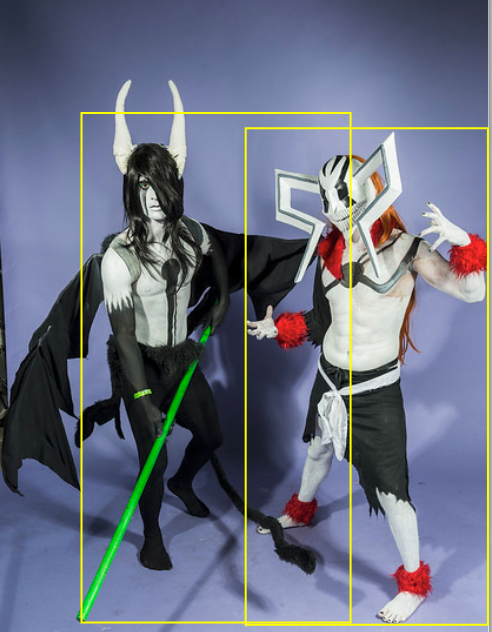

**Uwaga! Tą część projektu wykonujemy na lokalnym komputerze.**

Opisywanie zdjęć (annotation) to oznaczenie obiektów na zdjęciach. Nas interesuje obiekt 'Person' więc na wszystkich zdjęciach dla train i val musimy wykonać tę operację.

Im więcej zdjęc tym więcej pracy niestety.

Zdjęcie mogą mieć więcej obiektów (Person, Car, Dog, itp) ale oznaczamy tylko te klasy obiektów, które chcemy później rozpoznawać naszym modelem.

Oznaczanie zdjęć, czyli proces annotation, wykonywany jest w różych programach dla tego celu.

Proponuję aplikację LabelImg - https://github.com/tzutalin/labelImg

**Dostępna jest na różne systemy: Linux, Mac i Windows.**

Poradnik do LabelImg: https://youtu.be/p0nR2YsCY_U

Anotację dla zdjęc wykonujemy w formacie Pascal VOC. 

Dla każdego opisanego zdjęcia otrzymujemy zapis współrzędnych, wykonanego "prostokąta" na zdjęciu, w formacie xml.
W efekcie otrzymujemy parę jpg i xml dla każdego zdjęcia:


1.   zdjęcie_nr1.jpg
2.   zdjecie_nr1.xml

Możemy nasze wszystkie zdjęcia, będące w jednym folderze, w ten sposób opisać, a następnie podzielić odpowiednio na foldery train i val.
Możemy również wcześniej podzielić zdjęcia na train i val i wykonać anotację.

**W tym przykładzie moje zdjęcia zostały opisane klasą 'Person'.**


Takie gotowe już zdjęcia z plikami xml w formacie Pascal Vox można również ściągnąć z internetu z serwisów oferujących takie pakiety za free lub odpłatnie.

Przykład: https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=detection&c=%2Fm%2F01g317

Po wykonaniu opisu zdjęć na lokalnym komputerze przenosimy nasze zdjęcja, po podziale, wraz z plikami xml do folderów train i val na Google Drive.
W tym przypadku są to foldery:
1. /content/drive/MyDrive/HA_model_Coral/Person_Dataset/train
2. /content/drive/MyDrive/HA_model_Coral/Person_Dataset/val

Do folderu test możemy zapisać już tylko zdjęcja jpg, które na koniec sprawdzimy na naszym modelu.
Zdjęcia w poszczególnych folderach train, val i test muszą się oczywiście różnić od siebie :-)


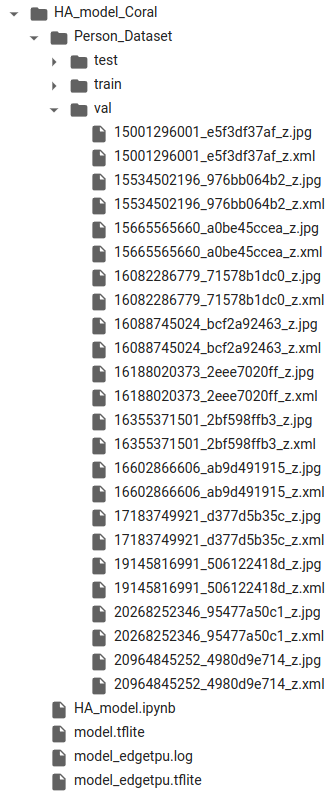

## **4. Instalacja niezbędnych pakietów oraz Tensorflow Lite Model Maker**


In [ ]:
!sudo apt -y install libportaudio2

#!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install tflite-model-maker-nightly

!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

## **5. Import bibliotek**

In [2]:
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import numpy as np
import os

import tensorflow as tf
assert tf.__version__.startswith('2')
print(tf.version.VERSION)

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

2.8.0


## **6. Ustawienia ścieżek do folderów**

Folder ze zdjęciami został zapisany w '/content/drive/MyDrive/HA_model_Coral'.

W tym folderze znajdują się zdjęcia podzielone na 3 podfoldery:
  

1.   train - zdjęcia do treningu modelu
2.   val   - zdjęcia do walidacji modelu
3.   test  - nowe zdjęcia, których model nie widział, do detekcji obiektów na gotowym modelu

Podział danych train/val/test w stosunku % np. 70/20/10

In [14]:
# Ścieżki wskazujące odpowiednio na dane treningowe i walidacyjne. Obrazy i anotacje XML znajdują się w:
train_image_dir = '/content/drive/MyDrive/HA_model_Coral/Person_Dataset/train'
val_image_dir = '/content/drive/MyDrive/HA_model_Coral/Person_Dataset/val'

# Tworzymy mapę etykiet. 
# Domyślnie 0 jest mapowane na tło zdjęcia, zaczynamy od 1 dla Person. 
# Jeżeli klas jest więcej to słownik wygląda następująco: {1:'Person', 2:'Car', 3:'Dog', .....}
# Mamy tylko jedną klasę - Person 
label_map={1:'Person'}

# Wczytujemy dane. Dane są wczytywane jako tfrecord i przechowywane w lokalizacji cache_dir do szybkiego wykorzystania w przyszłości.
# Zdjęcia trenigowe
train_ds = object_detector.DataLoader.from_pascal_voc(images_dir=train_image_dir,
                                                      annotations_dir= train_image_dir,
                                                      label_map=label_map,
                                                      cache_dir='/content/cache/train'
                                                     )
# Zdjęcia do walidacji.
val_ds = object_detector.DataLoader.from_pascal_voc(images_dir=val_image_dir,
                                                      annotations_dir= val_image_dir,
                                                      label_map=label_map,
                                                      cache_dir='/content/cache/val'
                                                     )

print("Zestaw treningowy zawiera {} zdjęć".format(train_ds.__len__()))
print("Zestaw do walidacji zawiera {} zdjęć".format(val_ds.__len__()))

Zestaw treningowy zawiera 35 zdjęć
Zestaw do walidacji zawiera 12 zdjęć


## **7. Specyfikacja modelu na bazie, którego utworzymy nasz własny model**

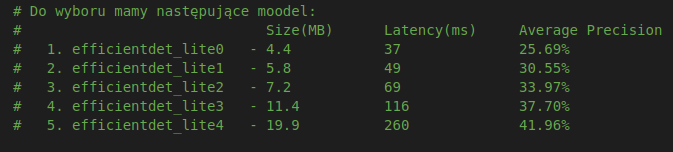

In [15]:
spec = model_spec.get("efficientdet_lite1")

## **8. Tworzymy model z wykorzystaniem tflite_model_maker API**

W zależności od liczby epochs i batch_siez tworzenie modelu może potrwać od kilkunastu do kilkudziesięciu minut a nawet dłużej ... :-)

In [ ]:
model = object_detector.ObjectDetector.create(train_data=train_ds,      #dataset treningowy
                                             model_spec=spec,           #specyfikacja modelu
                                             epochs=100,                #training epochs - na początek wystarczy 100.
                                             validation_data=val_ds,    #dataset do walidacji
                                             batch_size=4,              #dzielimy nasz zestaw zdjęć treningowe na paczki. Liczba_zdjęc / batch_sie = liczba iteracji.
                                             train_whole_model=True,    #Trenujemy cały model
                                             )

## **9. Ewaluacja modelu na danych testowych**

Ewaluacja utworzonego modelu - porównujemy precyzję utworzonego modelu na bazie danych treningowych.
Idealnie jest wykonać porównanie na danych których model jeszcze nie widział, ale w tym przypadku korzystamy z danych wykorzystanych do walidacji (val_ds).

Po zakończeniu walidacji otrzymamy listę metryk do oceny precyzji modelu.

In [17]:
model.evaluate(val_ds)

1/1 [==============================] - 8s 8s/step



{'AP': 0.52015793,
 'AP50': 0.86433226,
 'AP75': 0.55306554,
 'AP_/Person': 0.52015793,
 'APl': 0.5493322,
 'APm': 0.59996015,
 'APs': 0.0,
 'ARl': 0.6666667,
 'ARm': 0.675,
 'ARmax1': 0.4,
 'ARmax10': 0.585,
 'ARmax100': 0.635,
 'ARs': 0.0}

Kilka czynników może wpływać na dokładność modelu podczas eksportowania do TFLite:

* Kwantyzacja pomaga zmniejszyć rozmiar modelu czterokrotnie kosztem pewnego spadku dokładności.
* Oryginalny model TensorFlow wykorzystuje supresję non-max (NMS) dla klasy w post-processingu, podczas gdy model TFLite wykorzystuje globalny NMS, który jest znacznie szybszy, ale mniej dokładny. 
* Keras generuje maksymalnie 100 detekcji, podczas gdy tflite maksymalnie 25 detekcji.

Dlatego warto ocenić wyeksportowany model TFLite i porównać jego dokładność z oryginalnym modelem TensorFlow.

In [25]:
model.evaluate_tflite(model_path, val_ds)

12/12 [==============================] - 71s 6s/step



{'AP': 0.48949203,
 'AP50': 0.8814585,
 'AP75': 0.4138554,
 'AP_/Person': 0.48949203,
 'APl': 0.5067021,
 'APm': 0.59909993,
 'APs': 0.0,
 'ARl': 0.58,
 'ARm': 0.625,
 'ARmax1': 0.38,
 'ARmax10': 0.55,
 'ARmax100': 0.56,
 'ARs': 0.0}

W naszym przykładzie AP dla IOU=50% wynosi 0.88%. Całkiem nieźle!
AP/Person - 0.48, również OK.

## **10. Eksportujemy utworzony model do formatu TF Lite i zapisujemy na dysku**

Model w formacie tflite dla CPU.

**Uwaga!** Po zakończeniu eksportu modelu może pojawić się komunikat o błędzie:

*TypeError: EndVector() missing 1 required positional argument: 'vectorNumElems'*

Nie należy się tym przejmowąć - model powinień się zapisać w wskazanym folderze.
Komunikat o błędzie wynika z niezgodności bibliotek ale nie ma wpływu na wynik.


In [18]:
model.export(export_dir='/content/drive/MyDrive/HA_model_Coral')

## **11. Definiujemy ścieżkę do utworzonego modelu dla dalszych operacji**

In [19]:
model_path = '/content/drive/MyDrive/HA_model_Coral/model.tflite'

## **12. Funkcje pomocnicze do testowania naszego modelu tflite**

In [29]:
import cv2
from PIL import Image

lista_klas =['Person']                                                           # tu wpisujemy nazwy naszych klas (w naszym przypadku 'Person')
                                                   
# Wczytujemy nasze klasy obiektów do listy
classes = lista_klas * model.model_spec.config.num_classes                                  
label_map = model.model_spec.config.label_map                                               

print('Print label_map: ', label_map)

for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

Print label_map:  1: Person



## **13. Wykonujemy detekcję obrazów zapisanych w folderze testowym (test)**

Dostosuj DETECTION_THRESHOLD, aby zmienić czułość modelu. 

Niższy próg oznacza, że ​​model wykryje więcej obiektów, ale będzie też więcej fałszywych detekcji.

Tymczasem wyższy próg oznacza, że ​​model odbierze tylko te obiekty, które pewnie wykrył.

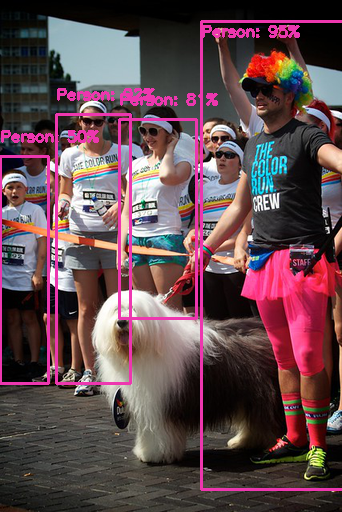

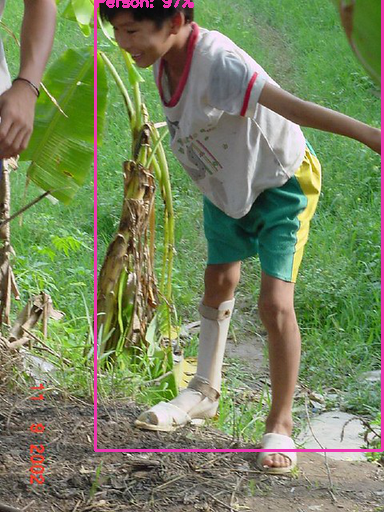

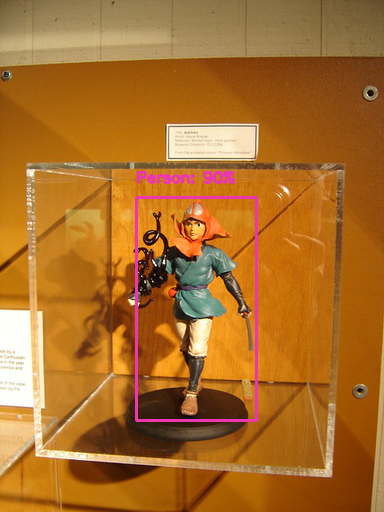

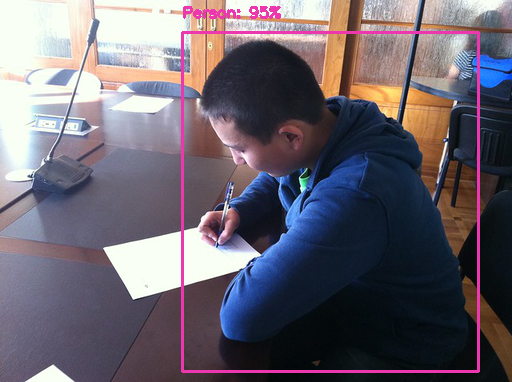

In [30]:
# Wczytujemy model TFLite
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

DETECTION_THRESHOLD = 0.3

directory = '/content/drive/MyDrive/HA_model_Coral/Person_Dataset/test'  #folder ze zdjęciami do testowania
JPG_FILES = []

for filename in os.listdir(directory):
    if filename.endswith(".jpg"): 
        JPG_FILES.append(os.path.join(directory, filename))
        continue
    else:
        continue

    print(JPG_FILES)

for JPG_FILE in JPG_FILES:
  im = Image.open(JPG_FILE)
  im.thumbnail((512, 512), Image.ANTIALIAS)
  im.save(JPG_FILE, 'PNG')

  # Uruchamiamy wnioskowanie i rysujemy wynik wykrywania obiektu na lokalnej kopii oryginalnego pliku w zestawie test
  detection_result_image = run_odt_and_draw_results(JPG_FILE, interpreter, threshold=DETECTION_THRESHOLD)

  # Pokaż wynik detekcji
  display(Image.fromarray(detection_result_image))
  print('\n')


Jeżeli detekcja została wykonana poprawnie możemy przejść do kolejnego kroku - eksport modelu tflite do formatu edge.tflie dla Coral.

Jeżeli detekcja na testowych zdjęciach nie jest poprawna, to nalezy wrócić do rozdziału nr. 8, gdzie
należy zwiększyć liczbę epochs oraz zmniejszyć liczbę batchy.
Ewentualnie należy dodać więcej zdjęć do zestawu treningowego.

## **14. Przygotowujemy środowisko do przekształcenia modelu TF Lite (CPU) do formatu Edge TPU(Coral)**

In [12]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  68567      0 --:--:-- --:--:-- --:--:-- 70472
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://security.ubunt

## **15. Kompilacja modelu dla Edge TPU (Coral)**

Wybierz liczbę Edge TPU i kompiluj!

EdgeTPU ma 8MB SRAM do buforowania parametrów modelu ([more info](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching)). Oznacza to, że dla modeli, które są większe niż 8MB, czas wnioskowania zostanie zwiększony w celu przeniesienia parametrów modelu. Jednym ze sposobów uniknięcia tego jest [Model Pipelining](https://coral.ai/docs/edgetpu/pipeline/) - podział modelu na segmenty, które mogą mieć dedykowane EdgeTPU. Może to znacznie poprawić opóźnienie.

Poniższa tabela może służyć jako odniesienie do liczby Edge TPU do użycia — większe modele nie skompilują się dla pojedynczego TPU, ponieważ tensory pośrednie nie mieszczą się w pamięci na chipie.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

In [13]:
NUMBER_OF_TPUS =  1

!edgetpu_compiler -o /content/drive/MyDrive/HA_model_Coral /content/drive/MyDrive/HA_model_Coral/model.tflite --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 6066 ms.

Input model: /content/drive/MyDrive/HA_model_Coral/model.tflite
Input size: 5.66MiB
Output model: /content/drive/MyDrive/HA_model_Coral/model_edgetpu.tflite
Output size: 7.57MiB
On-chip memory used for caching model parameters: 5.92MiB
On-chip memory remaining for caching model parameters: 1.58MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 322
Operation log: /content/drive/MyDrive/HA_model_Coral/model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 319
Number of operations t

Jeżeli na koniec pojawi się komunikat *Compilation succeeded!* to oznacza, że konwersja się udała.
Należy poczekać kilka sekund aż modelu edge zapisze się  w folderze wynikowym: /content/drive/MyDrive/HA_model_Coral

Model o nazwie model_edgetpu.tflite możemy następnie przenieść do Home Assistant (np. do Frigate).

frigate.yaml:

```
model:
  path: /media/frigate/models/model_edge.tflite
  labelmap_path: /media/frigate/models/labels.txt
  width: 320
  height: 320

```

W pliku labels.txt należy zapisać jedną klasę Person.

Jeżeli chcemy utworzyć własny model z większą liczbą klas to należy cały proces powtórzyć z odpowiednimi zdjęciami.

Zapisane modele dla CPU i Coral.

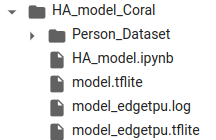